# 주문건수에 영향을 미치는 요인 회귀분석

#### 왜 해야하는가? -> 라이더에게 추천하기 위해 여러 계산을 할 때 가중치를 구하기 위해서!!

In [ ]:
# 하지만 고려될 수 있는 독립변수가 너무 적다. / 고려할 수 있는 것은 주문시간대 평균금액과 평균 배달시간 뿐
# 남녀 비율과 5세단위 세대구분을 어떻게 추가할 것인가?
# 주문시간대는 int이기 때문에 단순히 증가량으로만 인식, 원핫인코딩으로 구분해야할까?

# 20대 초반 기준 데이터 전처리 / 데이터 통합!

In [18]:
import pandas as pd

# 데이터 불러오기
df_delivery = pd.read_excel('./data/delivery/서울시간별통합파일.xlsx')
df_delivery.drop('Unnamed: 0', axis=1, inplace=True)
display(df_delivery.head())

df_classify = pd.read_excel('./data/delivery/서울성별나이별구분_201907.xlsx') 
df_classify.drop('Unnamed: 0', axis=1, inplace=True)
display(df_classify.head())
# 2019년 7월부터 데이터를 불러오자, 그리고 연월까지 추출해서 유니코드로 만든 뒤 배달 데이터에 추가해야 할 듯

,날짜,시간,시,구,평균시간,주문건수,평균주문금액
0,2019-07-18,0,서울특별시,구로구,22.65,16,23679
1,2019-07-18,0,서울특별시,동작구,22.17,1,15400
2,2019-07-18,0,서울특별시,영등포구,20.41,14,20864
3,2019-07-18,1,서울특별시,구로구,28.09,6,19667
4,2019-07-18,1,서울특별시,영등포구,22.19,8,18625


,기준연월,시,구,5세단위구분,총인구수,남성인구수,여성인구수
0,201907,서울특별시,종로구,20-24세,10947,5251,5696
1,201908,서울특별시,종로구,20-24세,10975,5272,5703
2,201909,서울특별시,종로구,20-24세,11032,5261,5771
3,201910,서울특별시,종로구,20-24세,10990,5238,5752
4,201911,서울특별시,종로구,20-24세,10950,5201,5749


In [29]:
# 배달 데이터 전처리
import pandas as pd
import numpy as np
import re

# 전처리 참고 블로그 : https://blog.naver.com/hankrah/222085743804

# 타임테이블로 바꿔서 출력하기
df_delivery['타임테이블'] = pd.to_datetime(df_delivery['날짜'])
df_delivery['기준연월'] = df_delivery['타임테이블'].dt.to_period(freq='M')

# 기준연월을 str로 변환
df_delivery['기준연월'] = df_delivery['기준연월'].astype(str)

# 기준연월에서 '-' 제거
# df_delivery['기준연월'] = re.sub('[-=.#/?:$}]', '', df_delivery['기준연월'])
df_delivery['기준연월'] = df_delivery['기준연월'].replace('[^\d.]', '',regex=True).astype(str)

# 유니코드 만들기 -> 
df_delivery['유니코드'] = df_delivery['기준연월'] + df_delivery['구']


df_delivery.info()
display(df_delivery)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64647 entries, 0 to 64646
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      64647 non-null  object        
 1   시간      64647 non-null  int64         
 2   시       64647 non-null  object        
 3   구       64647 non-null  object        
 4   평균시간    64647 non-null  float64       
 5   주문건수    64647 non-null  int64         
 6   평균주문금액  64647 non-null  int64         
 7   타임테이블   64647 non-null  datetime64[ns]
 8   기준연월    64647 non-null  object        
 9   유니코드    64647 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 4.9+ MB


,날짜,시간,시,구,평균시간,주문건수,평균주문금액,타임테이블,기준연월,유니코드
0,2019-07-18,0,서울특별시,구로구,22.65,16,23679,2019-07-18,201907,201907구로구
1,2019-07-18,0,서울특별시,동작구,22.17,1,15400,2019-07-18,201907,201907동작구
2,2019-07-18,0,서울특별시,영등포구,20.41,14,20864,2019-07-18,201907,201907영등포구
3,2019-07-18,1,서울특별시,구로구,28.09,6,19667,2019-07-18,201907,201907구로구
4,2019-07-18,1,서울특별시,영등포구,22.19,8,18625,2019-07-18,201907,201907영등포구
...,...,...,...,...,...,...,...,...,...,...
64642,2020-08-31,23,서울특별시,도봉구,22.76,4,30600,2020-08-31,202008,202008도봉구
64643,2020-08-31,23,서울특별시,양천구,24.33,8,26557,2020-08-31,202008,202008양천구
64644,2020-08-31,23,서울특별시,영등포구,24.36,44,18679,2020-08-31,202008,202008영등포구
64645,2020-08-31,23,서울특별시,용산구,33.07,1,20900,2020-08-31,202008,202008용산구


In [27]:
# 인구수 데이터 전처리
# 기준연월을 str로
df_classify['기준연월'] = df_classify['기준연월'].astype(str)

# 유니코드 만들기
df_classify['유니코드'] = df_classify['기준연월'] + df_classify['구']

display(df_classify)

,기준연월,시,구,5세단위구분,총인구수,남성인구수,여성인구수,유니코드
0,201907,서울특별시,종로구,20-24세,10947,5251,5696,201907종로구
1,201908,서울특별시,종로구,20-24세,10975,5272,5703,201908종로구
2,201909,서울특별시,종로구,20-24세,11032,5261,5771,201909종로구
3,201910,서울특별시,종로구,20-24세,10990,5238,5752,201910종로구
4,201911,서울특별시,종로구,20-24세,10950,5201,5749,201911종로구
...,...,...,...,...,...,...,...,...
295,202002,서울특별시,강동구,20-24세,26616,13482,13134,202002강동구
296,202003,서울특별시,강동구,20-24세,26866,13571,13295,202003강동구
297,202004,서울특별시,강동구,20-24세,26987,13592,13395,202004강동구
298,202005,서울특별시,강동구,20-24세,26974,13570,13404,202005강동구


In [37]:
# 데이터 합쳐보기
df_EDA = pd.merge(df_delivery, df_classify, how='inner', on='유니코드')

# 필요없는 컬럼 제거
df_EDA.drop(df_EDA.columns[[7,8,9,10,11,12]], axis=1, inplace=True)

# 컬럼 이름 변경
df_EDA.rename(columns = {'시_x':'시', '구_x':'구'}, inplace=True)

# 데이터 확인
display(df_EDA)

# 데이터 저장
df_EDA.to_excel('./data/delivery/회귀분석데이터.xlsx')

,날짜,시간,시,구,평균시간,주문건수,평균주문금액,5세단위구분,총인구수,남성인구수,여성인구수
0,2019-07-18,0,서울특별시,구로구,22.65,16,23679,20-24세,24384,12039,12345
1,2019-07-18,1,서울특별시,구로구,28.09,6,19667,20-24세,24384,12039,12345
2,2019-07-18,9,서울특별시,구로구,20.25,3,15167,20-24세,24384,12039,12345
3,2019-07-18,10,서울특별시,구로구,21.37,21,14721,20-24세,24384,12039,12345
4,2019-07-18,11,서울특별시,구로구,22.12,73,24563,20-24세,24384,12039,12345
...,...,...,...,...,...,...,...,...,...,...,...
55610,2020-06-29,15,서울특별시,서대문구,123.20,1,29000,20-24세,23011,10555,12456
55611,2020-06-29,16,서울특별시,서대문구,17.39,3,18900,20-24세,23011,10555,12456
55612,2020-06-30,21,서울특별시,서대문구,91.18,1,14000,20-24세,23011,10555,12456
55613,2020-06-30,22,서울특별시,서대문구,32.67,1,13700,20-24세,23011,10555,12456


# ====================================================
# ====================================================
# ====================================================
# ====================================================

# 회귀분석 들어가자

In [1]:
# 모듈설치
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "./data/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
import warnings
warnings.filterwarnings("ignore")


In [2]:
# 데이터 불러오기
df = pd.read_excel('./data/delivery/회귀분석데이터.xlsx')
display(df)


,Unnamed: 0,날짜,시간,시,구,평균시간,주문건수,평균주문금액,5세단위구분,총인구수,남성인구수,여성인구수
0,0,2019-07-18,0,서울특별시,구로구,22.65,16,23679,20-24세,24384,12039,12345
1,1,2019-07-18,1,서울특별시,구로구,28.09,6,19667,20-24세,24384,12039,12345
2,2,2019-07-18,9,서울특별시,구로구,20.25,3,15167,20-24세,24384,12039,12345
3,3,2019-07-18,10,서울특별시,구로구,21.37,21,14721,20-24세,24384,12039,12345
4,4,2019-07-18,11,서울특별시,구로구,22.12,73,24563,20-24세,24384,12039,12345
...,...,...,...,...,...,...,...,...,...,...,...,...
55610,55610,2020-06-29,15,서울특별시,서대문구,123.20,1,29000,20-24세,23011,10555,12456
55611,55611,2020-06-29,16,서울특별시,서대문구,17.39,3,18900,20-24세,23011,10555,12456
55612,55612,2020-06-30,21,서울특별시,서대문구,91.18,1,14000,20-24세,23011,10555,12456
55613,55613,2020-06-30,22,서울특별시,서대문구,32.67,1,13700,20-24세,23011,10555,12456


In [3]:
# 필요없는 컬럼 unnamed:0, 날짜, 시, 구, 5세단위구분, 남성인구수, 여성인구수 제거
df.drop(df.columns[[0,1,3,4,8,10,11]], axis=1, inplace=True)

df.columns

Index(['시간', '평균시간', '주문건수', '평균주문금액', '총인구수'], dtype='object')

In [4]:
display(df.head())
print(df.shape)

,시간,평균시간,주문건수,평균주문금액,총인구수
0,0,22.65,16,23679,24384
1,1,28.09,6,19667,24384
2,9,20.25,3,15167,24384
3,10,21.37,21,14721,24384
4,11,22.12,73,24563,24384


(55615, 5)


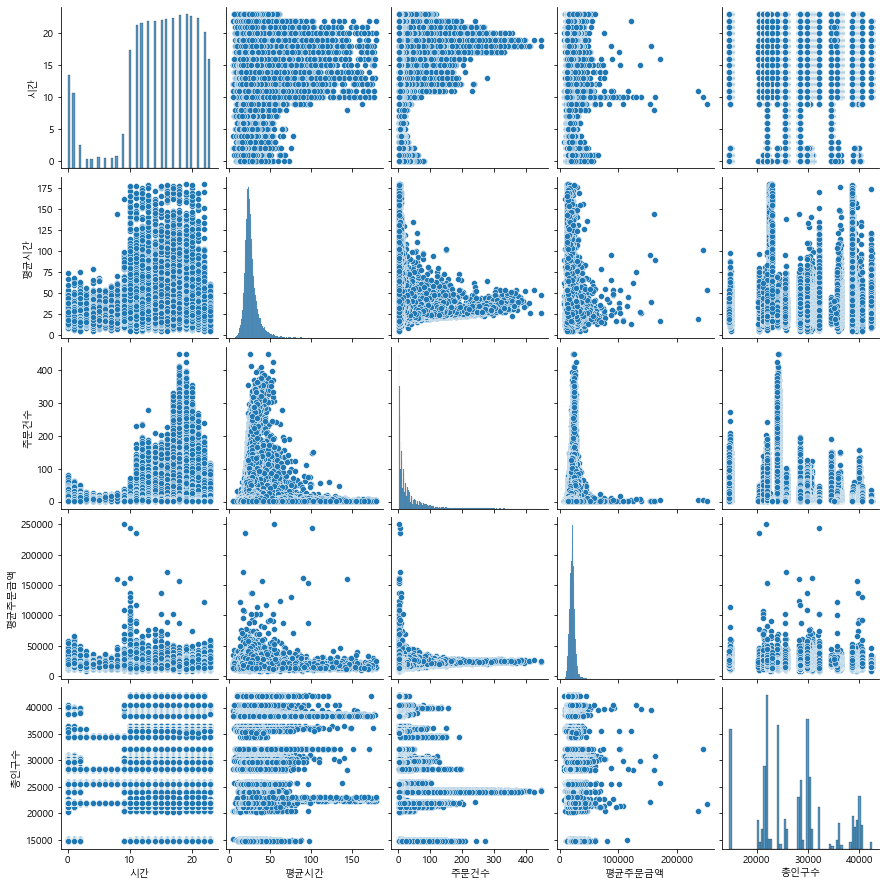

In [5]:
# 모든변수끼리 시각화

grid_df = sns.pairplot(df)
plt.savefig('./output/regression.png')
plt.show()


In [6]:
# 약간 망스멜?

# 표준화를 진행해봅시다

In [7]:
# 일단 표준화부터 한번 해봅시다.

In [8]:
# pandas 형태로 정의된 데이터를 출력할 때, scientific-notation이 아닌 float 모양으로 출력
pd.options.mode.chained_assignment = None

In [9]:
# 피처 각각에 대한 scaling을 수행하는 함수를 정의
# 표준편차와 평균을 이용해 스케일링 (Z score)

def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

In [34]:
# 피처 각각에 대한 scaling을 수행
scale_columns = ['평균시간', '평균주문금액', '총인구수']
re_df = standard_scaling(df, scale_columns)

In [35]:
re_df = re_df.rename(columns={'주문건수': 'y'})
re_df.head(5)

,시간,평균시간,y,평균주문금액,총인구수
0,0,-0.399011,16,0.399378,-0.37888
1,1,-0.027347,6,-0.334507,-0.37888
2,9,-0.562980,3,-1.157660,-0.37888
3,10,-0.486461,21,-1.239243,-0.37888
4,11,-0.435221,73,0.561082,-0.37888


In [36]:
# 시간 피처를 one-hot encoding으로 변환 --> 범주형이기 때문
time_encoding = pd.get_dummies(re_df['시간'])
re_df = re_df.drop(re_df.columns[0], axis=1)
re_df = re_df.join(time_encoding) # 합치기!

In [37]:
time_encoding.head(5)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
re_df.head(5)

,평균시간,y,평균주문금액,총인구수,0,1,2,3,4,5,...,14,15,16,17,18,19,20,21,22,23
0,-0.399011,16,0.399378,-0.37888,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.027347,6,-0.334507,-0.37888,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.562980,3,-1.157660,-0.37888,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.486461,21,-1.239243,-0.37888,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.435221,73,0.561082,-0.37888,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 학습 데이터와 테스트 데이터로 분리
X = re_df[re_df.columns.difference(['y'])]
y = re_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [18]:
# 회귀 분석 모델을 학습
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [19]:
# 회귀 분석 모델을 평가
print(model.score(X_train, y_train)) # train R2 score를 출력합니다.
print(model.score(X_test, y_test)) # test R2 score를 출력합니다.

0.2583872015758766
0.24870539112728418


In [20]:
# 회귀 분석 모델을 평가
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score를 출력합니다.
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score를 출력합니다.

# 차이의 제곱 값이 RMSE

39.3374843399196
39.9097209526107


# 변수들 간의 상관관계, 다중공선성 파악

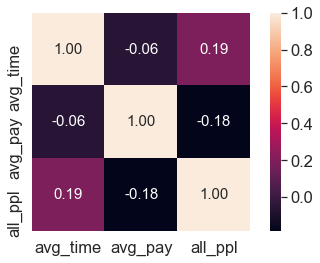

In [25]:
# 독립변수들 간의 공선성 파악

import seaborn as sns
from matplotlib import font_manager, rc
font_path = "./data/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 피처간의 상관계수 행렬을 계산
corr = re_df[scale_columns].corr(method='pearson')
show_cols = ['avg_time', 'avg_pay', 'all_ppl']

# corr 행렬 히트맵을 시각화
# plt.rc('font', family='malgun')
sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=show_cols,
            xticklabels=show_cols)

plt.tight_layout()
plt.show()

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [27]:
# 피처마다의 VIF 계수를 출력
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

# 값이 큰 것들을 날리기? 근데 의미가 없네

,VIF Factor,features
0,1.0,0
1,1.0,1
2,1.0,2
3,1.0,3
4,1.0,4
5,1.0,5
6,1.0,6
7,1.0,7
8,1.0,8
9,1.0,9


# 여기는 주희 코드!!

In [40]:
# 주희 코드

# module import!
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# # 데이터 불러오기
# df = pd.read_excel('./data/delivery/회귀분석데이터.xlsx')
# df.drop(df.columns[[0,1,3,4,8,10,11]], axis=1, inplace=True)
# df.info()


feature_columns = re_df.columns.difference(["y"]) # Target column 



X = re_df[feature_columns]
y = re_df['y']

train_x, test_x, train_y, test_y = train_test_split(X,y, train_size = 0.7, test_size = 0.3)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)


# train & 회귀모델 적합, 모든 변수를 때려넣었다.

# 회귀분석을 위해 for b0, 상수항 추가
train_x_ = sm.add_constant(train_x, has_constant = "add")

full_model = sm.OLS(train_y, train_x_)
fitted_full_model = full_model.fit()

fitted_full_model.summary()

(38930, 27) (16685, 27) (38930,) (16685,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     500.1
Date:                Thu, 26 Nov 2020   Prob (F-statistic):               0.00
Time:                        11:46:10   Log-Likelihood:            -1.9830e+05
No. Observations:               38930   AIC:                         3.967e+05
Df Residuals:                   38902   BIC:                         3.969e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.474e+12   3.44e+12     -2.463      0.014   -1.52e+13   -1.73e+12
0           8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
1           8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
2           8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
3           8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
4           8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
5           8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
6           8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
7           8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
8           8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
9           8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
10          8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
11          8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
12          8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
13          8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
14          8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
15          8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
16          8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
17          8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
18          8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
19          8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
20          8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
21          8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
22          8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
23          8.474e+12   3.44e+12      2.463      0.014    1.73e+12    1.52e+13
총인구수         -14.8152      0.209    -70.863      0.000     -15.225     -14.405
평균시간          -1.3522      0.210     -6.446      0.000      -1.763      -0.941
평균주문금액         4.0162      0.211     19.020      0.000       3.602       4.430
==============================================================================
Omnibus:                    23409.084   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           280159.190
Skew:                           2.725   Prob(JB):                         0.00
Kurtosis:                      14.959   Cond. No.                     9.79e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.26e-24. This might indicate

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   주문건수   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     1978.
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:42:16   Log-Likelihood:            -2.0060e+05
No. Observations:               38930   AIC:                         4.012e+05
Df Residuals:                   38925   BIC:                         4.012e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.0088      1.385     26.728      0.000      34.295      39.723
시간             1.8937      0.036     52.556      0.000       1.823       1.964
총인구수          -0.0020   3.07e-05    -64.917      0.000      -0.002      -0.002
평균시간           0.0713      0.015      4.785      0.000       0.042       0.101
평균주문금액         0.0009   3.98e-05     21.670      0.000       0.001       0.001
==============================================================================
Omnibus:                    25875.129   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           377816.157
Skew:                           3.050   Prob(JB):                         0.00
Kurtosis:                      16.990   Cond. No.                     2.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""